In [1]:
import os
import sys
import pprint
import csv
import statistics
import pandas as pd
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import radical.pilot as rp
import radical.utils     as ru
import radical.analytics as ra
import rp_analytics as rp_data
import parsl_analytics as parsl_data
from matplotlib import cm
blues = cm.get_cmap(plt.get_cmap('Blues'))
greens = cm.get_cmap(plt.get_cmap('Greens'))
reds = cm.get_cmap(plt.get_cmap('Reds'))
oranges = cm.get_cmap(plt.get_cmap('Oranges'))
purples = cm.get_cmap(plt.get_cmap('Purples'))
greys = cm.get_cmap(plt.get_cmap('Greys'))

# Font sizes
SIZE = 20
plt.rc('font'  , size      = SIZE  ) # controls default text sizes
plt.rc('axes'  , titlesize = SIZE  ) # fontsize of the axes title
plt.rc('axes'  , labelsize = SIZE  ) # fontsize of the x any y labels
plt.rc('xtick' , labelsize = SIZE  ) # fontsize of the tick labels
plt.rc('ytick' , labelsize = SIZE  ) # fontsize of the tick labels
plt.rc('legend', fontsize  = SIZE-2) # legend fontsize
plt.rc('figure', titlesize = SIZE  ) # size of the figure title

from IPython.core.display import display, HTML
# Expand the notebook to the width of the browser
display(HTML("<style>.container { width:100% !important; }</style>"))

# Matplotlib style
plt.style.use('seaborn-ticks')

# Use LaTeX and its body font for the diagrams' text.
#mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']
mpl.rcParams['font.family'] = 'DejaVu Sans'

In [2]:
!radical-stack
!which python


  python               : 3.6.10
  pythonpath           : 
  virtualenv           : conda-parsl

  radical.analytics    : 0.90.7
  radical.pilot        : 1.4.1
  radical.saga         : 1.4.0
  radical.utils        : 1.4.0

/home/aymen/anaconda3/envs/conda-parsl/bin/python


In [3]:
RP    = rp_data.get_session_tstamps()
PARSL = parsl_data.get_session_tstamps()
PARSL

session loaded
row invalid [../RP/sessions/rp.session.js-17-185.jetstream-cloud.org.aymen.018439.0013/pilot.0000/agent_staging_output_queue.prof]: ['1593194548.7241380', 'sl']
session loaded
session loaded
session loaded
session loaded
session loaded
session loaded
session loaded


,Session,Duration
0,session0001.1N,320.699
1,session0003.1N,322.844
2,session0000.1N,341.682
3,session0002.1N,366.275
4,session0000.72N,1275.638
5,session0001.72N,1882.113
6,session.0002.72N,3468.378


In [4]:
RP

,Session,Duration
0,rp.session.js-17-185.jetstream-cloud.org.aymen...,584.267033
1,rp.session.js-17-185.jetstream-cloud.org.aymen...,593.792082
2,rp.session.js-17-185.jetstream-cloud.org.aymen...,601.295664
3,rp.session.js-17-185.jetstream-cloud.org.aymen...,602.321817
4,rp.session.js-17-185.jetstream-cloud.org.aymen...,2245.421590
5,rp.session.js-17-185.jetstream-cloud.org.aymen...,2383.158255
6,rp.session.js-17-185.jetstream-cloud.org.aymen...,2730.871165
7,rp.session.js-17-185.jetstream-cloud.org.aymen...,2737.687748


8.350594497838266 21.150249779429956


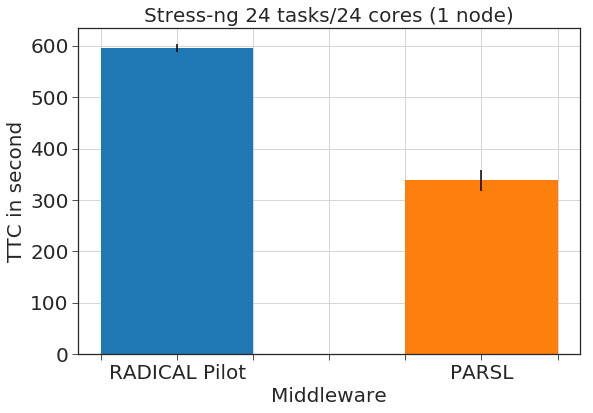

In [5]:
rp_std = statistics.stdev(RP['Duration'][:4])
parsl_std = statistics.stdev(PARSL['Duration'][:4])
print(rp_std, parsl_std)
# create figure and axis objects with subplots()
fig,ax=plt.subplots(figsize=(9,6))
RP_gr = statistics.mean(RP['Duration'][:4])
PARSL_gr = statistics.mean(PARSL['Duration'][:4])
ax.bar(1,RP_gr,yerr=rp_std, width=0.5)
ax.set_xlabel("Middleware")
ax.set_ylabel("TTC in second")
ax.bar(2,PARSL_gr, yerr=parsl_std, width=0.5)
ax.grid()
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[2] = 'RADICAL Pilot'
labels[6] = 'PARSL'
ax.title.set_text("Stress-ng 24 tasks/24 cores (1 node)")
ax.set_xticklabels(labels)
plt.show()
fig.savefig('../figures/parsl-rp-24.pdf', dpi=300, bbox_inches='tight')

248.9311392523976 1132.2659643811996


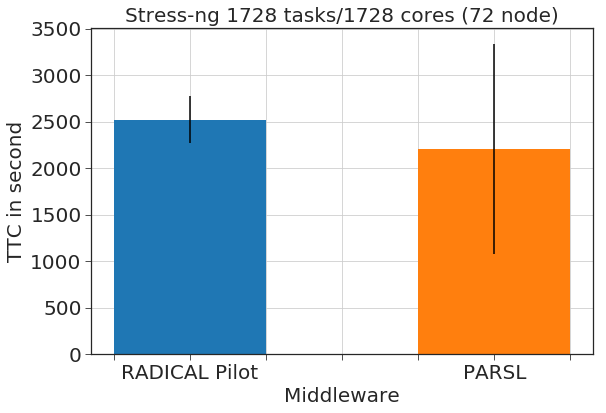

In [6]:
rp_std = statistics.stdev(RP['Duration'][4:])
parsl_std = statistics.stdev(PARSL['Duration'][4:])
print(rp_std, parsl_std)
# create figure and axis objects with subplots()
fig,ax=plt.subplots(figsize=(9,6))
RP_gr = statistics.mean(RP['Duration'][4:])
PARSL_gr = statistics.mean(PARSL['Duration'][4:])
ax.bar(1,RP_gr,yerr=rp_std, width=0.5)
ax.set_xlabel("Middleware")
ax.set_ylabel("TTC in second")
ax.bar(2,PARSL_gr, yerr=parsl_std, width=0.5)
ax.grid()
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[2] = 'RADICAL Pilot'
labels[6] = 'PARSL'
ax.title.set_text("Stress-ng 1728 tasks/1728 cores (72 node)")
ax.set_xticklabels(labels)
plt.show()
fig.savefig('../figures/parsl-rp-72.pdf', dpi=300, bbox_inches='tight')

In [7]:
ss = {}
loc = [dI for dI in os.listdir('../RP/sessions/') if os.path.isdir(os.path.join('../RP/sessions/',dI))]
print (len(loc))
for session in range(len(loc)):
    sp = os.path.join('../RP/sessions/',loc[session])
    ss[session] = {'s': ra.Session(sp, 'radical.pilot')}
    ss[session].update({'p': ss[session]['s'].filter(etype='pilot'   , inplace=False),
                        'u': ss[session]['s'].filter(etype='unit'    , inplace=False)})
    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21]
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                  # gray        [24]

# Scale the RGB values to the [0, 1] range, which is the format
# matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (round(r/255.,1), round(g/255.,1), round(b/255.,1))

8
session loaded
session loaded
session loaded
row invalid [../RP/sessions/rp.session.js-17-185.jetstream-cloud.org.aymen.018439.0013/pilot.0000/agent_staging_output_queue.prof]: ['1593194548.7241380', 'sl']
session loaded
row invalid [../RP/sessions/rp.session.js-17-185.jetstream-cloud.org.aymen.018439.0013/pilot.0000/agent_staging_output_queue.prof]: ['1593194548.7241380', 'sl']
session loaded
row invalid [../RP/sessions/rp.session.js-17-185.jetstream-cloud.org.aymen.018439.0013/pilot.0000/agent_staging_output_queue.prof]: ['1593194548.7241380', 'sl']
session loaded
session loaded
session loaded
session loaded
session loaded
session loaded
session loaded
session loaded
session loaded
session loaded
session loaded
session loaded
session loaded
session loaded
session loaded
session loaded
session loaded
session loaded
session loaded


In [8]:
from radical.pilot import states as rps

for sid in range(len(loc)):
    u  = ss[sid]['u']

    ss[sid].update({
        'umgr_sched_queue'  : u.duration( event=[{ru.STATE: rps.NEW                        },
                                                 {ru.STATE: rps.UMGR_SCHEDULING            } ]), 
        'umgr_stage_input'  : u.duration( event=[{ru.STATE: rps.UMGR_STAGING_INPUT_PENDING },
                                                 {ru.STATE: rps.UMGR_STAGING_INPUT         } ]), 
        'agent_stage_input' : u.duration( event=[{ru.STATE: rps.AGENT_STAGING_INPUT_PENDING},
                                                 {ru.STATE: rps.AGENT_SCHEDULING_PENDING   } ]), 
        'agent_sched_queue' : u.duration( event=[{ru.STATE: rps.AGENT_SCHEDULING_PENDING   },
                                                 {ru.EVENT: 'schedule_ok'                  } ]), 
        'agent_exec_queue'  : u.duration( event=[{ru.EVENT: 'schedule_ok'                  },
                                                 {ru.STATE: rps.AGENT_EXECUTING            } ]),
        'agent_exec_prep'   : u.duration( event=[{ru.STATE: rps.AGENT_EXECUTING            },
                                                 {ru.EVENT: 'exec_start'                   } ]),
        'agent_exec_rp'     : u.duration( event=[{ru.EVENT: 'exec_start'                   },
                                                 {ru.EVENT: 'cu_start'                     } ]),
        'agent_exec_sh'     : u.duration( event=[{ru.EVENT: 'cu_start'                     },
                                                 {ru.EVENT: 'cu_exec_start'                } ]),
        'agent_exec_cmd'    : u.duration( event=[{ru.EVENT: 'cu_exec_start'                },
                                                 {ru.EVENT: 'cu_exec_stop'                 } ]),
        'agent_term_sh'     : u.duration( event=[{ru.EVENT: 'cu_exec_stop'                 },
                                                 {ru.EVENT: 'cu_stop'                      } ]),
        'agent_term_rp'     : u.duration( event=[{ru.EVENT: 'cu_stop'                      },
                                                 {ru.EVENT: 'exec_stop'                    } ]),
        'agent_unschedule'  : u.duration( event=[{ru.EVENT: 'exec_stop'                    },
                                                 {ru.EVENT: 'unschedule_stop'              } ]),
        'agent_stage_output': u.duration( event=[{ru.EVENT: 'unschedule_stop'              },
                                                 {ru.STATE: rps.UMGR_STAGING_OUTPUT        } ])
    })

In [9]:
ss

{0: {'s': <radical.analytics.session.Session at 0x7fe6566992b0>,
  'p': <radical.analytics.session.Session at 0x7fe65d96a4a8>,
  'u': <radical.analytics.session.Session at 0x7fe64bbeec18>,
  'umgr_sched_queue': 3.0273115634918213,
  'umgr_stage_input': 28.824687719345093,
  'agent_stage_input': 1638.495926618576,
  'agent_sched_queue': 1.298135757446289,
  'agent_exec_queue': 129.7829623222351,
  'agent_exec_prep': 197.18617963790894,
  'agent_exec_rp': 199.09069538116455,
  'agent_exec_sh': 177.0,
  'agent_exec_cmd': 498.0,
  'agent_term_sh': 139.0,
  'agent_term_rp': 119.62970924377441,
  'agent_unschedule': 38.4412100315094,
  'agent_stage_output': 144.50637125968933},
 1: {'s': <radical.analytics.session.Session at 0x7fe63a181208>,
  'p': <radical.analytics.session.Session at 0x7fe627409198>,
  'u': <radical.analytics.session.Session at 0x7fe614141e80>,
  'umgr_sched_queue': 2.6722593307495117,
  'umgr_stage_input': 14.3182954788208,
  'agent_stage_input': 1953.7778165340424,
  'ag

In [10]:
for sid in range(len(loc)):
    print("""
%s:
\tumgr_sched_queue  : %s
\tumgr_stage_input  : %s
\tagent_stage_input : %s
\tagent_sched_queue : %s
\tagent_exec_queue  : %s
\tagent_exec_prep   : %s
\tagent_exec_rp     : %s
\tagent_exec_sh     : %s
\tagent_exec_cmd    : %s
\tagent_term_sh     : %s
\tagent_term_rp     : %s
\tagent_unschedule  : %s
\tagent_stage_output: %s
""" % (sid                         , 
       ss[sid]['umgr_sched_queue'] ,
       ss[sid]['umgr_stage_input'] ,
       ss[sid]['agent_stage_input'],
       ss[sid]['agent_sched_queue'],
       ss[sid]['agent_exec_queue'] , 
       ss[sid]['agent_exec_prep']  , 
       ss[sid]['agent_exec_rp']    , 
       ss[sid]['agent_exec_sh']    , 
       ss[sid]['agent_exec_cmd']   , 
       ss[sid]['agent_term_sh']    , 
       ss[sid]['agent_term_rp']    , 
       ss[sid]['agent_unschedule'] ,
       ss[sid]['agent_stage_output']))


0:
	umgr_sched_queue  : 3.0273115634918213
	umgr_stage_input  : 28.824687719345093
	agent_stage_input : 1638.495926618576
	agent_sched_queue : 1.298135757446289
	agent_exec_queue  : 129.7829623222351
	agent_exec_prep   : 197.18617963790894
	agent_exec_rp     : 199.09069538116455
	agent_exec_sh     : 177.0
	agent_exec_cmd    : 498.0
	agent_term_sh     : 139.0
	agent_term_rp     : 119.62970924377441
	agent_unschedule  : 38.4412100315094
	agent_stage_output: 144.50637125968933


1:
	umgr_sched_queue  : 2.6722593307495117
	umgr_stage_input  : 14.3182954788208
	agent_stage_input : 1953.7778165340424
	agent_sched_queue : 1.3785820007324219
	agent_exec_queue  : 186.64848041534424
	agent_exec_prep   : 259.5842356681824
	agent_exec_rp     : 260.23859214782715
	agent_exec_sh     : 243.0
	agent_exec_cmd    : 561.0
	agent_term_sh     : 185.0
	agent_term_rp     : 158.64473056793213
	agent_unschedule  : 44.744903326034546
	agent_stage_output: 203.639714717865


2:
	umgr_sched_queue  : 0.07364940643

In [11]:
for sid in range(len(loc)):
    u  = ss[sid]['u']
    p  = ss[sid]['p']

    ss[sid].update({
      'ttc'  : p.duration(event=[ {ru.EVENT: 'state'         , ru.STATE: rp.NEW                }, 
                                   {ru.EVENT: 'state'        , ru.STATE: rp.CANCELED           } ]),
      'ttq_p': p.duration(event=[ {ru.EVENT: 'state'         , ru.STATE: rp.PMGR_ACTIVE_PENDING}, 
                                   {ru.EVENT: 'state'        , ru.STATE: rp.PMGR_ACTIVE        } ]),
      'ttx_u': u.duration( event=[ {ru.EVENT: 'cu_exec_start', ru.STATE: None                  },      
                                   {ru.EVENT: 'cu_exec_stop' , ru.STATE: None                  } ]),
      'ttx_p': p.duration(event=[ {ru.EVENT: 'state'         , ru.STATE: rp.PMGR_ACTIVE        },
                                  [{ru.EVENT: 'state'        , ru.STATE: rp.DONE               },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.FAILED             },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.CANCELED           }]])})
    
    ss[sid].update({'ovh_rtc':(ss[sid]['ttx_p'])-ss[sid]['ttx_u']})

In [12]:
ss[2]['ttq_p']

74.20410370826721

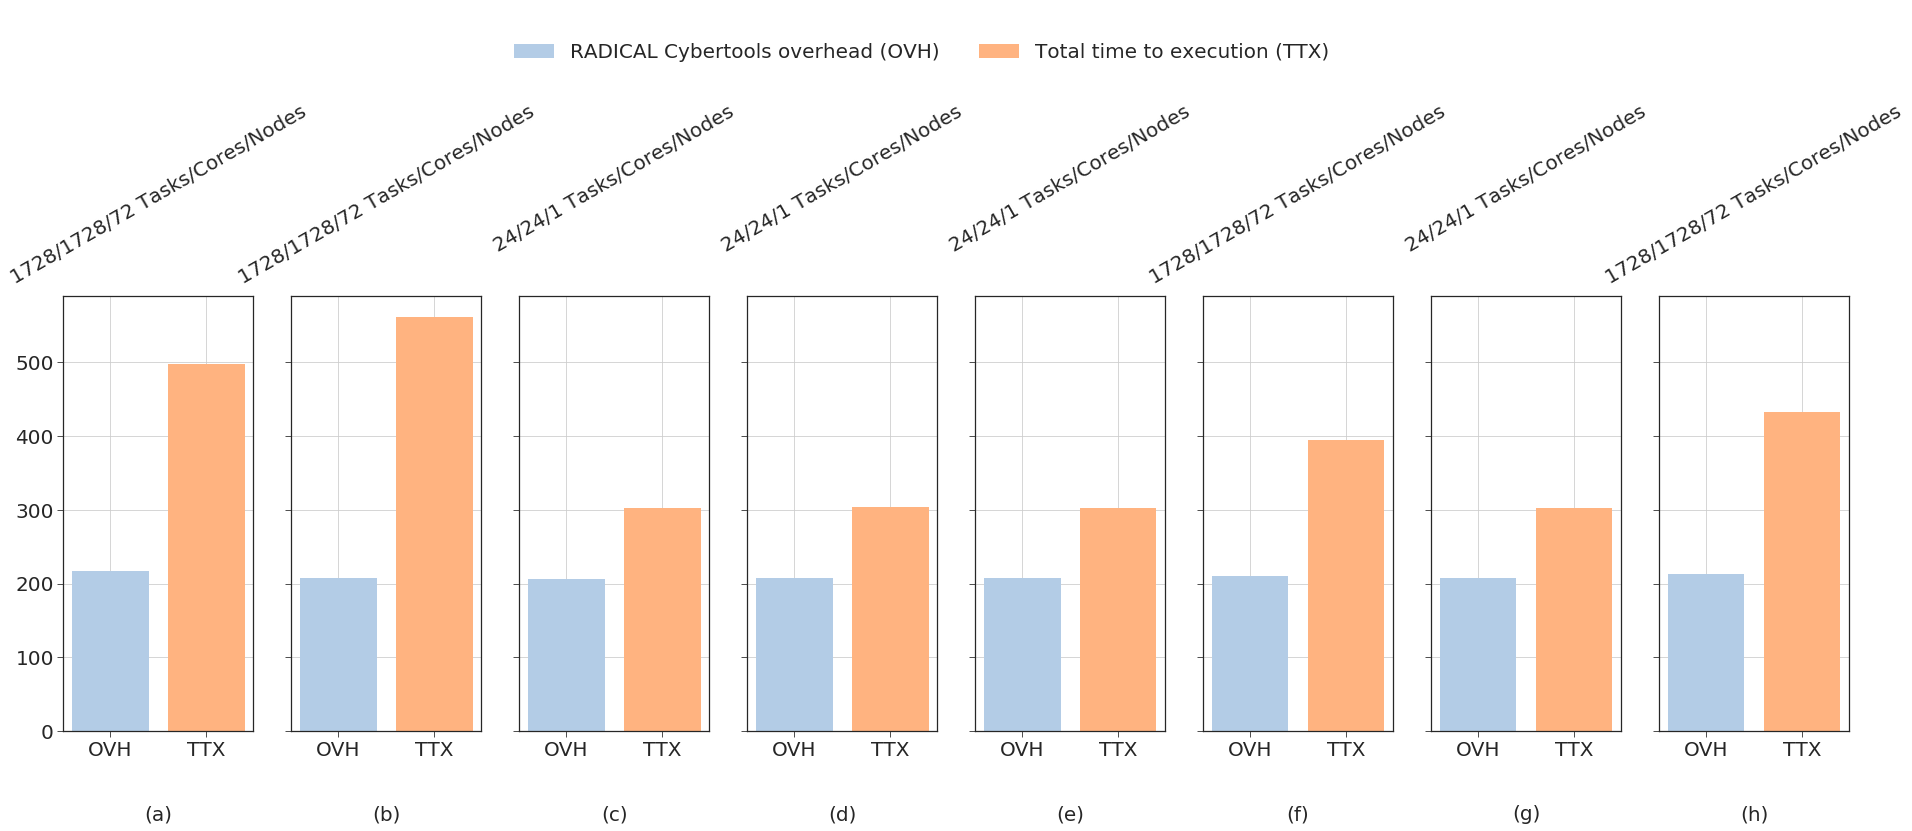

In [13]:
fwidth = 32
fhight = 8
fig, axarr = plt.subplots(1, len(loc), sharey=True, figsize=(fwidth, fhight))

i = 0
j = 'a'
for sid in range(len(loc)):
    nunit = len(ss[sid]['u'].get())
    nnodes= nunit/24
    ncore = nunit
    ax = axarr[i]
    ax.set_title('%s/%s/%s Tasks/Cores/Nodes' % (int(nunit),int(ncore), int(nnodes)), rotation = 30,y=1.4)
    #ax.title.set_text('%s/%s/%s Tasks/Cores/Nodes' % (24,24, int(1)))
    
    ax.bar(x = 'OVH', height = ss[sid]['ovh_rtc'], color = tableau20[1])
    ax.bar(x = 'TTX', height = ss[sid]['ttx_u']  , color = tableau20[3])
    ax.grid()
    ax.set_xlabel('(%s)' % j, labelpad=45)
    
    i = i+1
    j = chr(ord(j) + 1)


fig.legend(['RADICAL Cybertools overhead (OVH)', 'Total time to execution (TTX)'], loc='upper center', 
           bbox_to_anchor=(0.4, 1.4), fontsize=20, ncol=2)
plt.savefig('../figures/rp_aggregated_overheads.pdf', dpi=300, bbox_inches='tight')

## Breaking Down the sessions based on their events

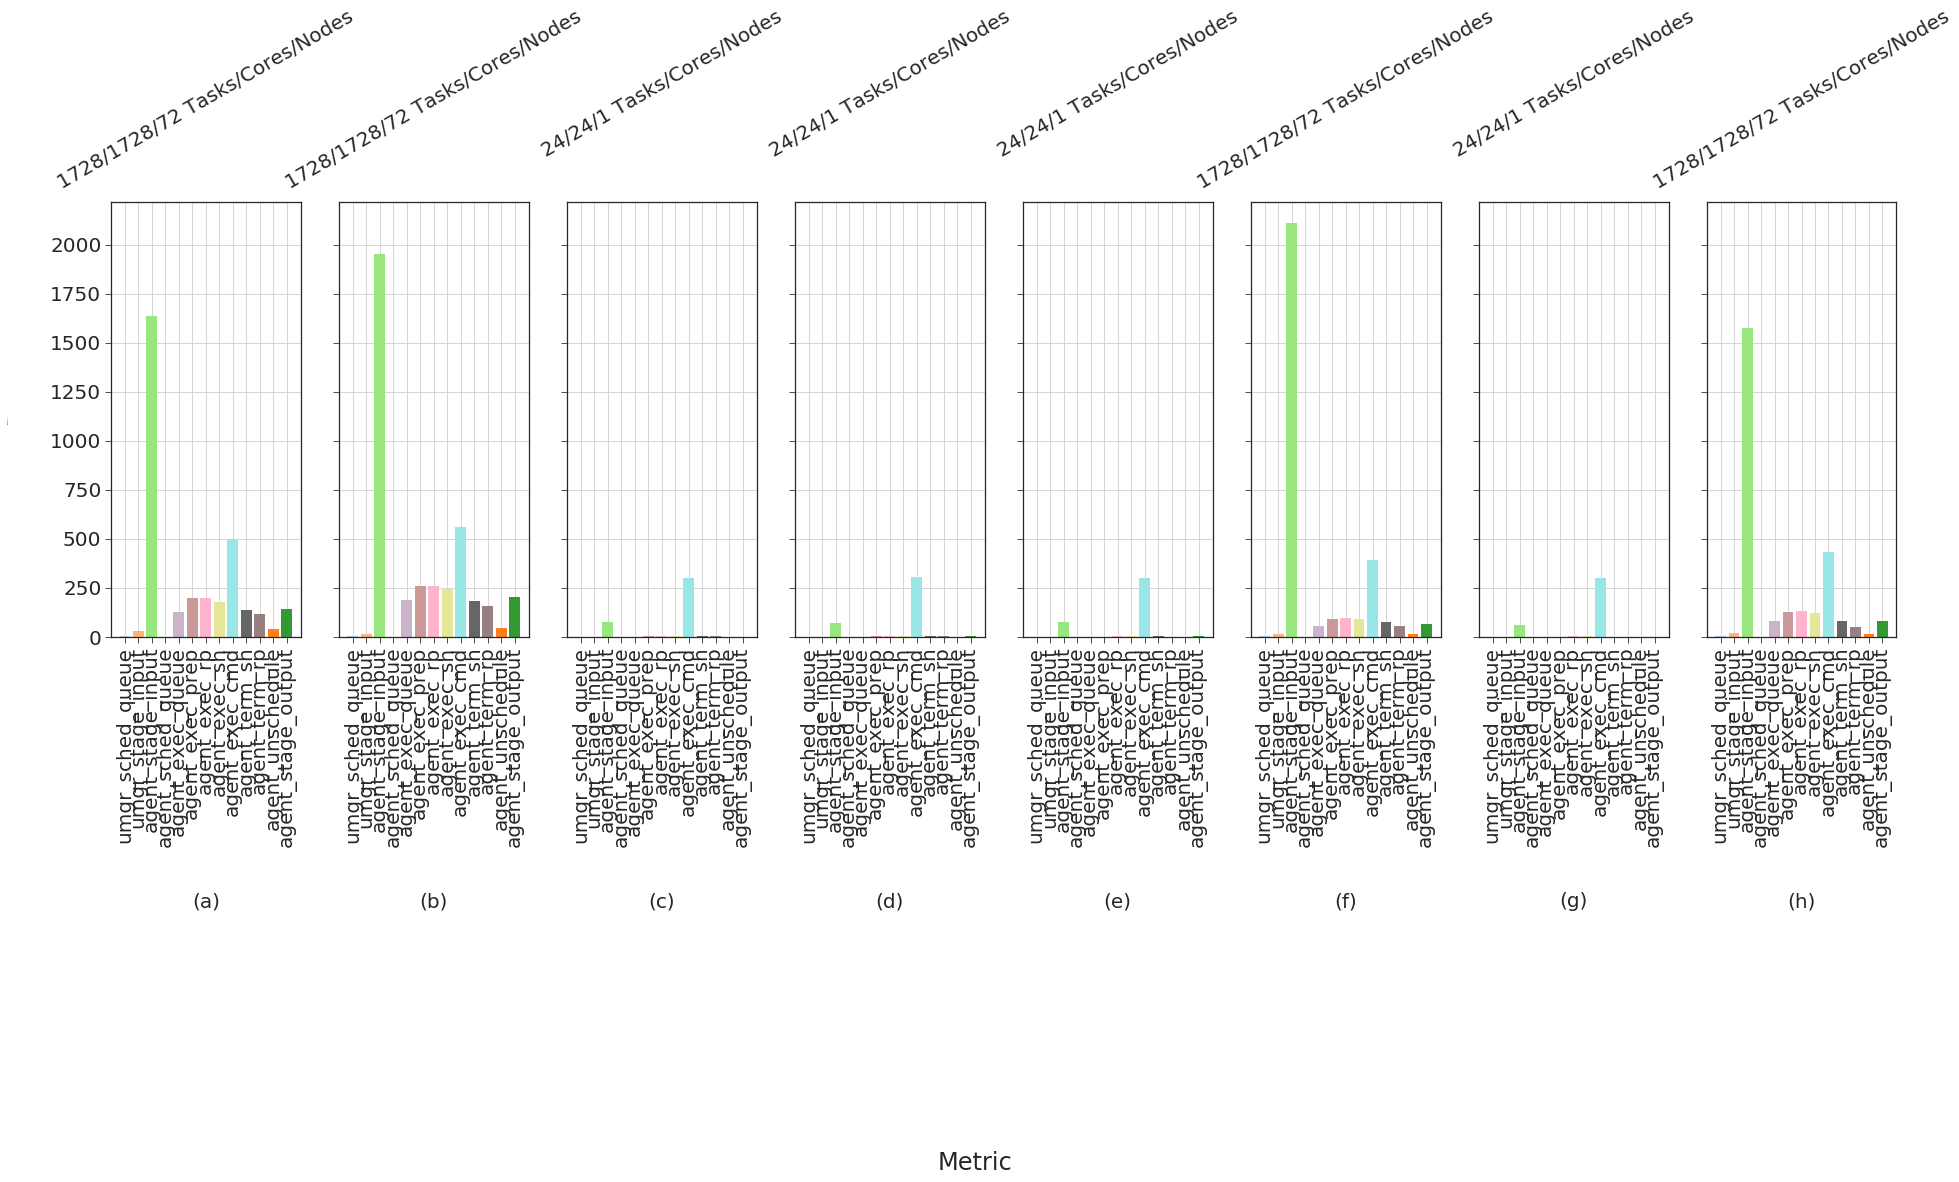

In [14]:
plt.rc('text', usetex=False)

fwidth = 32
fhight = 8
fig, axarr = plt.subplots(1,  len(loc), sharey=True, figsize=(fwidth, fhight))

i = 0
j = 'a'


for sid in range(len(loc)):
    
    ax = axarr[i]
    nunit = len(ss[sid]['u'].get())
    nnodes= nunit/24
    ncore = nunit
    ax = axarr[i]
    ax.set_title('%s/%s/%s Tasks/Cores/Nodes' % (int(nunit),int(ncore), int(nnodes)), rotation = 30,y=1.4)
    #ax.title.set_text('%s/%s/%s Tasks/Cores/Nodes' % (24,24, int(1)))

    ax.bar(x = 'umgr_sched_queue', height = ss[sid]['umgr_sched_queue'], color = tableau20[1])
    ax.bar(x = 'umgr_stage_input', height = ss[sid]['umgr_stage_input'], color = tableau20[3])
    ax.bar(x = 'agent_stage_input', height = ss[sid]['agent_stage_input'], color = tableau20[5])
    ax.bar(x = 'agent_sched_queue', height = ss[sid]['agent_sched_queue'], color = tableau20[7])
    ax.bar(x = 'agent_exec_queue', height = ss[sid]['agent_exec_queue'], color = tableau20[9])
    ax.bar(x = 'agent_exec_prep', height = ss[sid]['agent_exec_prep'], color = tableau20[11])
    ax.bar(x = 'agent_exec_rp', height = ss[sid]['agent_exec_rp'], color = tableau20[13])
    ax.bar(x = 'agent_exec_sh', height = ss[sid]['agent_exec_sh'], color = tableau20[15])
    ax.bar(x = 'agent_exec_cmd', height = ss[sid]['agent_exec_cmd'], color = tableau20[17])
    ax.bar(x = 'agent_term_sh', height = ss[sid]['agent_term_sh'], color = tableau20[19])
    ax.bar(x = 'agent_term_rp', height = ss[sid]['agent_term_rp'], color = tableau20[21])
    ax.bar(x = 'agent_unschedule', height = ss[sid]['agent_unschedule'], color = tableau20[2])
    ax.bar(x = 'agent_stage_output', height = ss[sid]['agent_stage_output'], color = tableau20[4])
    ax.grid()
    ax.set_xlabel('(%s)' % j, labelpad=45)
    ax.tick_params(axis='x', labelrotation=90)
    
    i = i+1
    j = chr(ord(j) + 1)

fig.text(0.08,  0.5 , 'Time (s)', va='center', rotation='vertical', fontsize=2)
fig.text(0.5 , -0.8 , 'Metric'  , ha='center', fontsize=24)
fig.savefig('../figures/rp-session-events.pdf', dpi=300, bbox_inches='tight')

## Breaking down the units of a single session based on their time stamps

row invalid [../RP/sessions/rp.session.js-17-185.jetstream-cloud.org.aymen.018439.0013/pilot.0000/agent_staging_output_queue.prof]: ['1593194548.7241380', 'sl']
session loaded
#entities: 1728


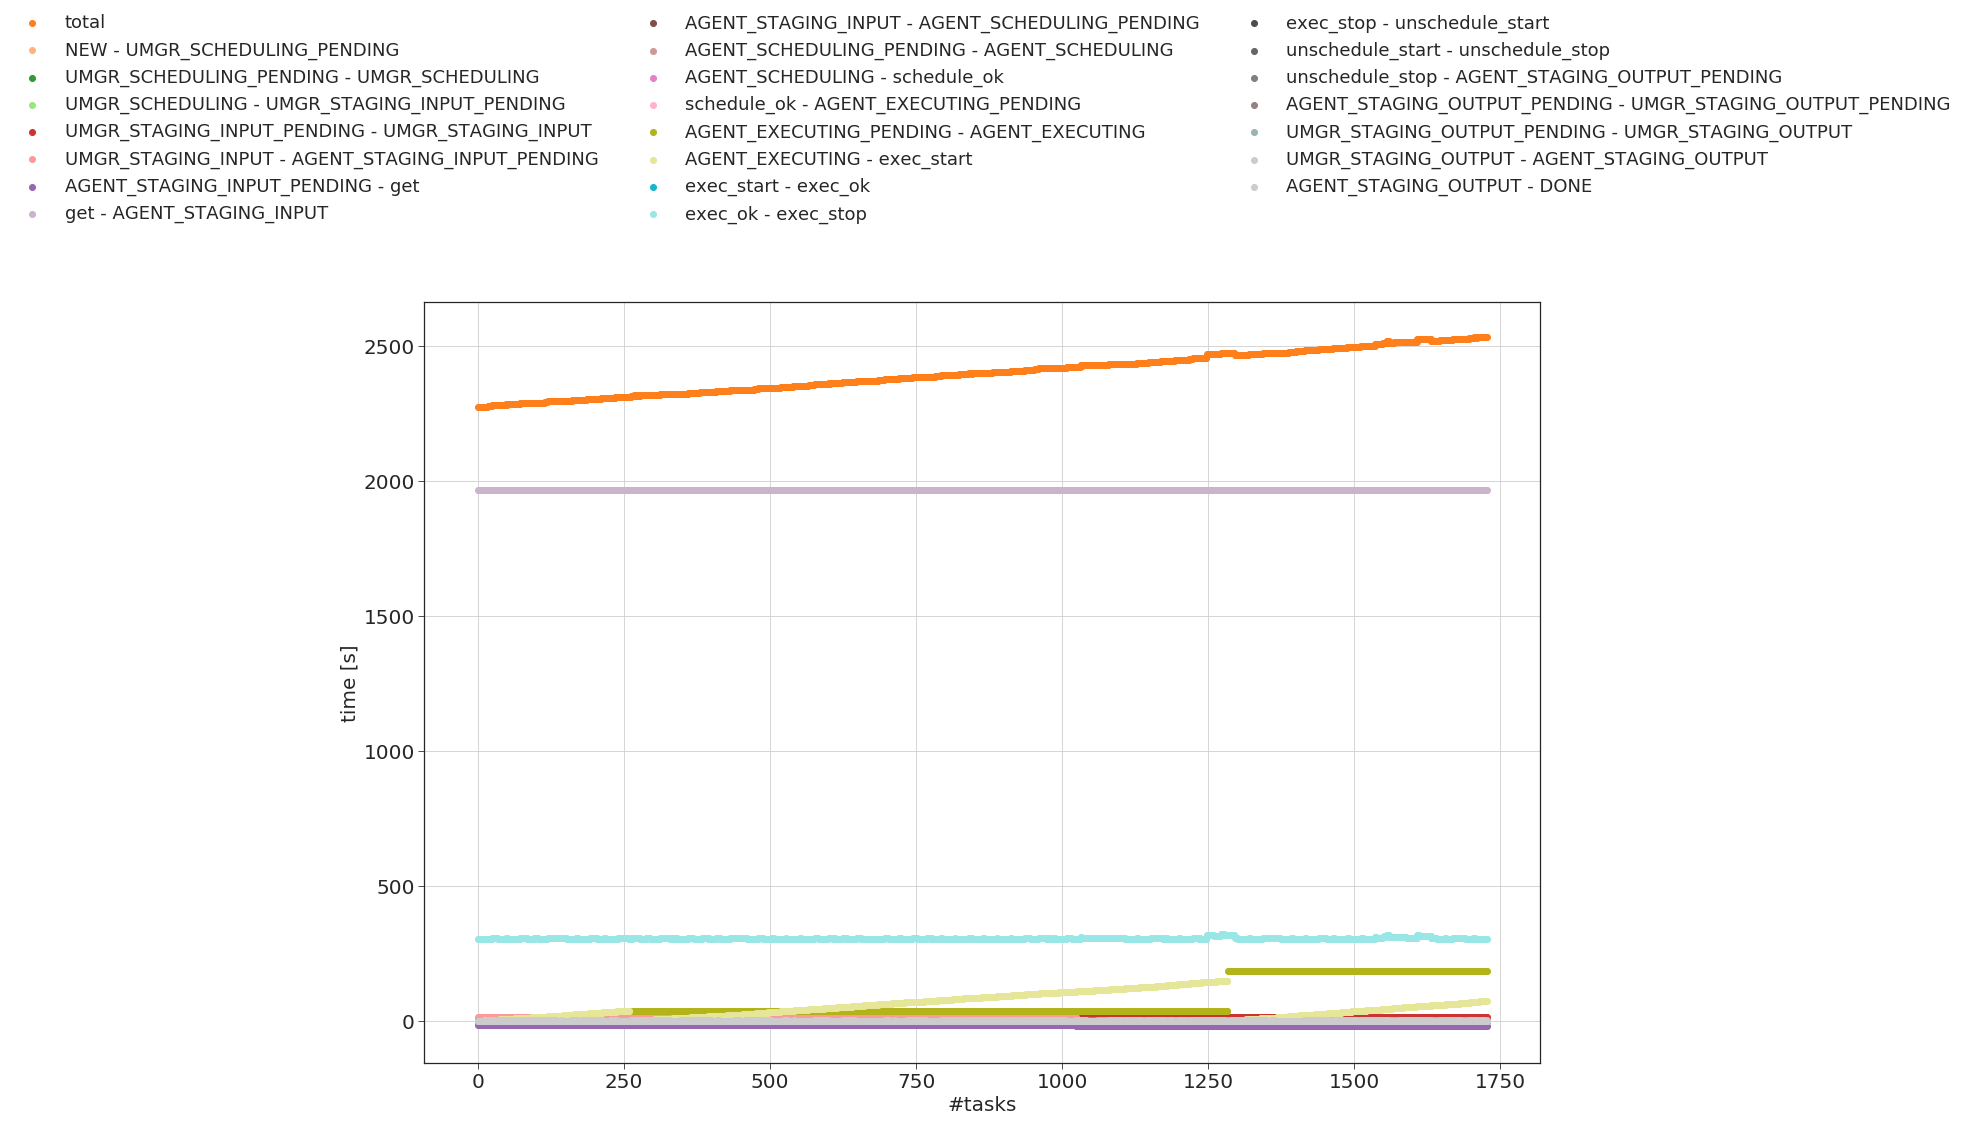

In [15]:
event_list   = \
    [
     {ru.STATE: 'NEW'                          , ru.EVENT: 'state'           },
     {ru.STATE: 'UMGR_SCHEDULING_PENDING'      , ru.EVENT: 'state'           },
     {ru.STATE: 'UMGR_SCHEDULING'              , ru.EVENT: 'state'           },
     {ru.STATE: 'UMGR_STAGING_INPUT_PENDING'   , ru.EVENT: 'state'           },
     {ru.STATE: 'UMGR_STAGING_INPUT'           , ru.EVENT: 'state'           },
     {ru.STATE: 'AGENT_STAGING_INPUT_PENDING'  , ru.EVENT: 'state'           },
     {ru.STATE: None                           , ru.EVENT: 'get'             },
     {ru.STATE: 'AGENT_STAGING_INPUT'          , ru.EVENT: 'state'           },
     {ru.STATE: 'AGENT_SCHEDULING_PENDING'     , ru.EVENT: 'state'           },
     {ru.STATE: 'AGENT_SCHEDULING'             , ru.EVENT: 'state'           },
     {ru.STATE: None                           , ru.EVENT: 'schedule_ok'     },
     {ru.STATE: 'AGENT_EXECUTING_PENDING'      , ru.EVENT: 'state'           },
     {ru.STATE: 'AGENT_EXECUTING'              , ru.EVENT: 'state'           },
     {ru.STATE: None                           , ru.EVENT: 'exec_start'      },
     {ru.STATE: None                           , ru.EVENT: 'exec_ok'         },
     {ru.STATE: None                           , ru.EVENT: 'exec_stop'       },
     {ru.STATE: None                           , ru.EVENT: 'unschedule_start'},
     {ru.STATE: None                           , ru.EVENT: 'unschedule_stop' },
     {ru.STATE: 'AGENT_STAGING_OUTPUT_PENDING' , ru.EVENT: 'state'           },
     {ru.STATE: 'UMGR_STAGING_OUTPUT_PENDING'  , ru.EVENT: 'state'           },
     {ru.STATE: 'UMGR_STAGING_OUTPUT'          , ru.EVENT: 'state'           },
     {ru.STATE: 'AGENT_STAGING_OUTPUT'         , ru.EVENT: 'state'           },
     {ru.STATE: 'DONE'                         , ru.EVENT: 'state'           },
    ]
    
def ppheader(message):
    separator = '\n' + 78 * '-' + '\n'
    print(separator + message + separator)
    
loc = [dI for dI in os.listdir('../RP/sessions/') if os.path.isdir(os.path.join('../RP/sessions/',dI))]

src = os.path.dirname(loc[1])
sid = os.path.basename(loc[1])
session = ra.Session(sid=sid, stype='radical.pilot', src=os.path.join('../RP/sessions/',loc[1]))
print (session)
session.filter(etype='unit', inplace=True)

print('#entities: %d' % len(session.get()))

data = dict()
for thing in session.get():

    tstamps = list()

    for event in event_list:
        times = thing.timestamps(event=event)
        if times: tstamps.append(times[0])
        else    : tstamps.append(np.nan)

    data[thing.uid] = tstamps

# We sort the entities by the timestamp of the first event
# We also derive the durations, first the individual contributions, then the
# overall duration.
# timestamp in the list
sorted_things = sorted(list(data.items()), key=lambda e: e[1][0])
sorted_data   = list()
index         = 0
for uid,tstamps in sorted_things:

    durations = list()
    durations.append(tstamps[-1] - tstamps[0])  # global duration
    for i in range(len(tstamps) - 1):
        durations.append(tstamps[i + 1] - tstamps[i])

    # create plottable data
    sorted_data.append([index] + durations)
    index += 1

# create a numpyarray for plotting
np_data = np.array(sorted_data)
# print np_data

plt.figure(figsize=(20,14))
plt.ylabel('time [s]')
plt.xlabel('#tasks')
for e_idx in range(len(event_list)):
    if e_idx == 0:
        label = 'total'
    else:
        label = '%s - %s' % (ru.event_to_label(event_list[e_idx - 1]),
                             ru.event_to_label(event_list[e_idx]))
    plt.scatter(np_data[:,0], np_data[:,(1 + e_idx)], label=label, color = tableau20[e_idx+2])
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4),ncol=3, fancybox=True)
plt.savefig('../figures/rp_unit_dur-72N.pdf', dpi=300, bbox_inches='tight')

In [16]:
UNIT_DURATIONS_DEBUG = {
    'consume' : {
        'u_umngr_create'               : [ {ru.EVENT: 'state'           , ru.STATE: rp.NEW                         },      
                                         {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_SCHEDULING_PENDING     }  ],
        'u_umngr_schedule_queue'       : [ {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_SCHEDULING_PENDING     }, 
                                         {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_SCHEDULING             }  ],
        'u_umngr_schedule'             : [ {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_SCHEDULING             },               
                                         {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_INPUT_PENDING  }  ],
        'u_umngr_stage_in_queue'       : [ {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_INPUT_PENDING  }, 
                                         {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_INPUT          }  ], # push to mongodb
        'u_umngr_stage_in'             : [ {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_INPUT          }, 
                                         {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_INPUT_PENDING }  ], # wait in mongodb
        'u_agent_stage_in_queue'       : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_INPUT_PENDING },  
                                         {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_INPUT         }  ], # pull from mongodb 
        'u_agent_stage_in'             : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_INPUT         },  
                                         {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_SCHEDULING_PENDING    }  ], 
        'u_agent_schedule_queue'       : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_SCHEDULING_PENDING    },  
                                         {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_SCHEDULING            }  ],
        'u_agent_schedule'             : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_SCHEDULING            },  
                                         {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_EXECUTING_PENDING     }  ], 
        'u_agent_execute_queue'        : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_EXECUTING_PENDING     },  
                                         {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_EXECUTING             }  ], 
        'u_agent_execute_mkdir_start'  : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_EXECUTING             },  
                                         {ru.EVENT: 'exec_mkdir'      , ru.STATE: None                           }  ], 
        'u_agent_execute_mkdir'        : [ {ru.EVENT: 'exec_mkdir'      , ru.STATE: None                           },
                                         {ru.EVENT: 'exec_mkdir_done' , ru.STATE: None                           }  ],
        'u_agent_execute_layer_start'  : [ {ru.EVENT: 'exec_mkdir_done' , ru.STATE: None                           },
                                         {ru.EVENT: 'exec_start'      , ru.STATE: None                           }  ],
        'u_agent_execute_layer'        : [ {ru.EVENT: 'exec_start'      , ru.STATE: None                           },
                                        [{ru.EVENT: 'exec_ok'         , ru.STATE: None                           },
                                         {ru.EVENT: 'exec_fail'       , ru.STATE: None                           } ]], # orte, ssh, mpi, ... 

        'u_agent_cu_start'             : [ {ru.EVENT: 'cu_start'        , ru.STATE: None                           },
                                         {ru.EVENT: 'cu_cd_done'      , ru.STATE: None                           }  ], # PROBLEM: discontinuity
        'u_agent_cu_pre_execute_start' : [ {ru.EVENT: 'cu_cd_done'      , ru.STATE: None                           },
                                         {ru.EVENT: 'cu_pre_start'    , ru.STATE: None                           }  ],
        'u_agent_cu_pre_execute'       : [ {ru.EVENT: 'cu_pre_start'    , ru.STATE: None                           },
                                         {ru.EVENT: 'cu_pre_stop'     , ru.STATE: None                           }  ],
        'u_agent_cu_execute_start'     : [ {ru.EVENT: 'cu_pre_stop'     , ru.STATE: None                           },
                                         {ru.EVENT: 'cu_exec_start'   , ru.STATE: None                           }  ],
        'u_agent_cu_execute'           : [ {ru.EVENT: 'cu_exec_start'   , ru.STATE: None                           },
                                         {ru.EVENT: 'cu_exec_stop'    , ru.STATE: None                           }  ],
        'u_agent_cu_stop'              : [ {ru.EVENT: 'cu_exec_stop'    , ru.STATE: None                           },
                                         {ru.EVENT: 'cu_stop'         , ru.STATE: None                           }  ],

        'u_agent_cu_unschedule_start'  : [ {ru.EVENT: 'exec_stop'       , ru.STATE: None                           },
                                         {ru.EVENT: 'unschedule_start', ru.STATE: None                           }  ], # PROBLEM: discontinuity
        'u_agent_cu_stage_out_start'   : [ {ru.EVENT: 'unschedule_start', ru.STATE: None                           },
                                         {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_OUTPUT_PENDING}  ],
        'u_agent_cu_stage_out_queue'   : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_OUTPUT_PENDING},
                                         {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_OUTPUT        }  ],
        'u_agent_cu_stage_out'         : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_OUTPUT        },
                                         {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_OUTPUT_PENDING }  ],
#         'u_agent_cu_unschedule_stop'   : [ {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_OUTPUT_PENDING },
#                                          {ru.EVENT: 'unschedule_stop' , ru.STATE: None                           }  ],
        'u_agent_cu_push_to_umngr'     : [ {ru.EVENT: 'unschedule_stop' , ru.STATE: None                           },
                                         {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_OUTPUT         }  ], # push/pull mongodb
        'u_umngr_cu_destroy'           : [ {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_OUTPUT         },
                                        [{ru.EVENT: 'state'           , ru.STATE: rp.DONE                        },
                                         {ru.EVENT: 'state'           , ru.STATE: rp.CANCELED                    },
                                         {ru.EVENT: 'state'           , ru.STATE: rp.FAILED                      } ]]
    }
}

In [17]:
u_durations = {}

for sid in range(len(loc)):
    u_durations[sid] = {}

for sid in range(len(loc)):
    for uid in ss[sid]['u'].list('uid'):
        unit = ss[sid]['u'].get(etype='unit', uid=uid)[0]
        durations = {}
        for k,v in UNIT_DURATIONS_DEBUG['consume'].items():
            try:
                
                durations[k] = unit.duration(event=v)
            except:
                pass
        u_durations[sid].update({uid: durations})

In [18]:
u_durations_df = {}
for sid,durations in u_durations.items():
    u_durations_df[sid] = pd.DataFrame.from_dict(durations, orient='index')

/home/aymen/anaconda3/envs/conda-parsl/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/home/aymen/anaconda3/envs/conda-parsl/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1253: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/home/aymen/anaconda3/envs/conda-parsl/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1261: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
/home/aymen/anaconda3/envs/conda-parsl/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1262: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


Text(0.5, 0, 'time (s)')

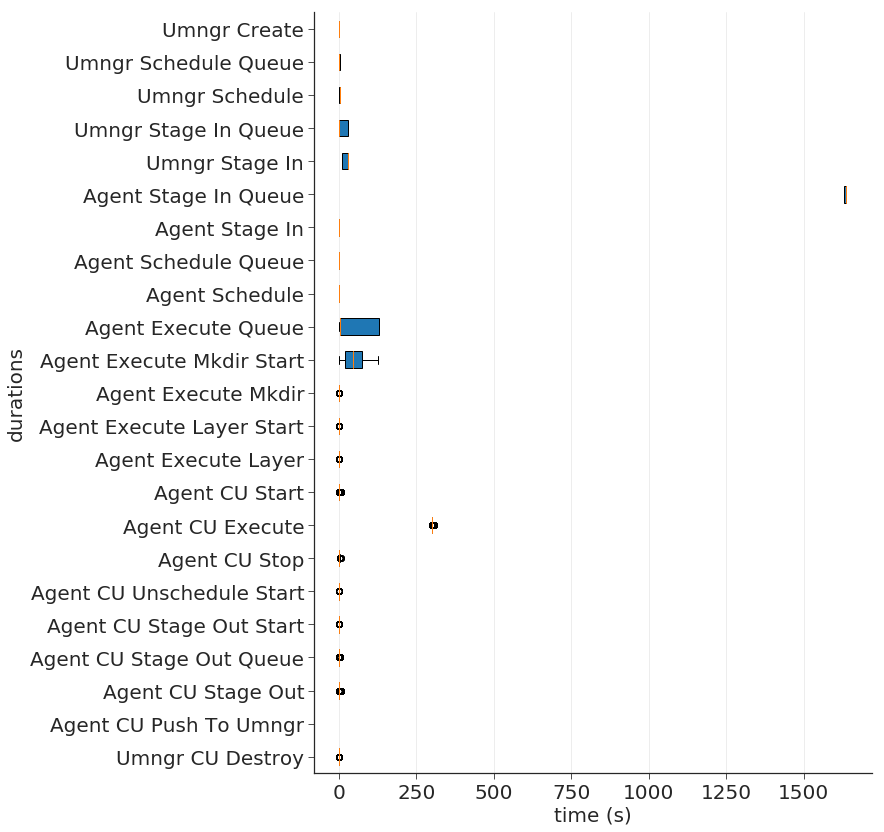

In [19]:
def fig_setup(figsize=None):
    if not figsize:
        figsize = (13,7)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    return fig, ax



fig, ax  = fig_setup(figsize=(10,14))


labels = []
#muted = ['u_agent_schedule', 'u_agent_cu_execute']

durations = u_durations_df[0]#.drop(muted, axis=1)

for label in durations.columns:
    labels.append(label.replace("_", " ").title().replace("U ", "").replace("Cu", "CU"))
labels = list(reversed(labels))

boxes = []
for duration in list(reversed(durations.columns)):
    boxes.append(durations[duration].values)    

plt.boxplot(boxes, patch_artist=True, labels=labels, vert=False),

ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
ax.set_axisbelow(True)

plt.ylabel('durations')
plt.xlabel('time (s)')

## The amount of time the units lived in Mongo-DB waiting for the pilot to startup and to be scheduled 

In [20]:
import pprint
dur = list()
for unit in range(len(sorted_things)):
    AScP  = sorted_things[unit][1][9] #AGENT_SCHEDULING_PENDING only if the agent is running and pilot is running (That means it already passed the queue time) 
    AStIP = sorted_things[unit][1][6] #AGENT_STAGING_INPUT_PENDING'
    MongoDB_unit_time = AScP-AStIP  #Amount of time the unit waited in the Database to be scheduled 
    dur.append(MongoDB_unit_time)
dur[1030]

1968.04185795784

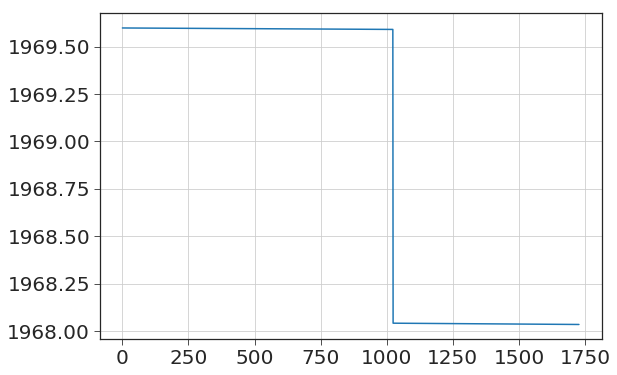

In [21]:
df = pd.DataFrame(list(zip(dur)), columns =['MongDB_unit_time']) 
df.plot(figsize=(9,6), grid=True, legend= False)